<a href="https://colab.research.google.com/github/Bhargavi1504/Regression-algorithms/blob/main/Ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#1.data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import random

np.random.seed(42)
n_samples=1000

missing_fraction = 0.1
duplicate_fraction = 0.05
outlier_fraction = 0.03

#functions
def random_generator_cat(choices,n):
  return np.random.choice(choices,n)

def generate_dates(n):
  base = datetime.today()
  return [base - timedelta(days=random.randint(0,2000)) for _ in range(n_samples)]

#raw features
Age = np.random.randint(5,80,n_samples)
experience=np.clip(Age - np.random.randint(18,25,n_samples),0,None)
education= random_generator_cat(['Bachelors','Masters','PHD'],n_samples)
city = random_generator_cat(['New York', 'San Francisco', 'Chicago', 'Austin'],n_samples)
job_role = random_generator_cat(['Data Scientist','Data Analyst','Data Engineer'],n_samples)
gender = random_generator_cat(['Male', 'Female', 'Other'], n_samples)
join_date = generate_dates(n_samples)
performance = np.random.normal(70,10,n_samples).round(2)
working_hours= np.random.normal(40,5,n_samples).round(1)
married = np.random.choice([0, 1], n_samples)
social_activity = np.random.normal(2, 1, n_samples).round(1)

# Multicollinear & noisy features
salary=experience * 3000 + Age* 200 + np.random.normal(0,1000,n_samples)
loan_amount = salary * 0.3 + np.random.normal(0,5000,n_samples)
spending_score= np.random.normal(50,20,n_samples).round(1)
rating = np.random.randint(1, 6, n_samples)
target_salary = salary * 1.1 + np.random.normal(0, 3000, n_samples)
will_churn = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])


# 4. Create DataFrame
d=pd.DataFrame({
    'Age': Age,
    'salary': salary.round(2),
    'experience': experience,
    'education_level': education,
    'city': city,
    'job_role': job_role,
    'gender': gender,
    'join_date': join_date,
    'performance': performance,
    'working_hours': working_hours,
    'married': married,
    'loan_amount': loan_amount.round(2),
    'spending_score': spending_score,
    'rating': rating,
    'social_activity': social_activity,
    'target_salary': target_salary.round(2),
    'will_churn': will_churn
})

# Inject Missing Values
for i in d.columns:
  d.loc[d.sample(frac = missing_fraction).index,i]=np.nan

# Inject Duplicates
num_duplicates = int(n_samples * duplicate_fraction )
duplicate_rows = d.sample(num_duplicates)
d=pd.concat([d,duplicate_rows],ignore_index=True)

# Inject Outliers
def inject_outliers(d,column,fraction = outlier_fraction,factor=10):
    num_outliers = int(len(d)* fraction)
    indices = np.random.choice(d.index,num_outliers,replace=True)
    d.loc[indices,column] *= factor

inject_outliers(d, 'salary')
inject_outliers(d, 'loan_amount')

# Encode Categorical for ML
d_encoded=d.copy()
label_cols= ['education_level', 'city', 'job_role', 'gender']
encoders={}
for c in label_cols:
  le=LabelEncoder()
  d_encoded[c] = d_encoded[c].astype(str) #avoid NaNs
  d_encoded[c]=le.fit_transform(d_encoded[c])
  encoders[c]= le

# 9. Export
# -------------------------------
d.to_csv("dirty_dataset.csv", index=False)
d_encoded.to_csv("dirty_dataset_encoded.csv", index=False)

print("✅ Dirty dataset and encoded version saved!")


✅ Dirty dataset and encoded version saved!


In [31]:
dr=pd.read_csv('dirty_dataset_encoded.csv')
print('initial shape',dr.shape)

initial shape (1050, 17)


In [33]:
#missing
#--target nans
dr=dr.dropna(subset=['target_salary'])
from sklearn.impute import SimpleImputer
num_c=dr.select_dtypes(include=['int64','float64']).columns
imputer=SimpleImputer(strategy='median')
dr[num_c]=imputer.fit_transform(dr[num_c])

#--for cat
dr['join_date']=dr['join_date'].fillna(dr['join_date'].mode()[0])
print('missing values are:',dr.isnull().sum())



#outliers
def remove_outliers(d,i):
  q1=d[i].quantile(0.25)
  q3=d[i].quantile(0.75)
  iqr=q3-q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  mask=(d[i] >=lower)&(d[i]<=upper)
  return d[mask]

for i in ['salary','loan_amount','target_salary']:
  dr = remove_outliers(dr,i)

print("Shape after outlier removal:", dr.shape)

missing values are: Age                0
salary             0
experience         0
education_level    0
city               0
job_role           0
gender             0
join_date          0
performance        0
working_hours      0
married            0
loan_amount        0
spending_score     0
rating             0
social_activity    0
target_salary      0
will_churn         0
dtype: int64
Shape after outlier removal: (915, 17)


In [35]:
#3.3 Feature & Target Split + Scaling
from sklearn.preprocessing import StandardScaler

# Features and Target
X = dr.drop(columns=['target_salary', 'will_churn','join_date'])
y = dr['target_salary']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [36]:
#splitting
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [37]:
#model building
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score

# Alpha is the regularization strength (higher = more penalty)
model = Ridge(alpha=10)
model.fit(x_train,y_train)

# Predict & Evaluate
y_pred=model.predict(x_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test, y_pred)

print("📉 RMSE:", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))

📉 RMSE: 14742.31
📈 R² Score: 0.9513


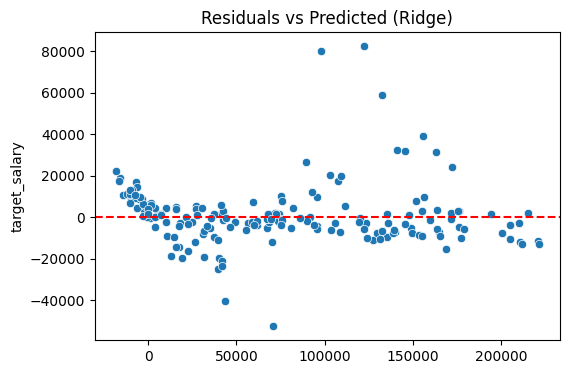

In [38]:
#Step 5: Diagnostic Checks
#Residuals vs Predictions (Check Linearity)
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (Ridge)")
plt.show()

#Random scatter around 0 → good linear fit
#Funnel shape = possible non-linearity

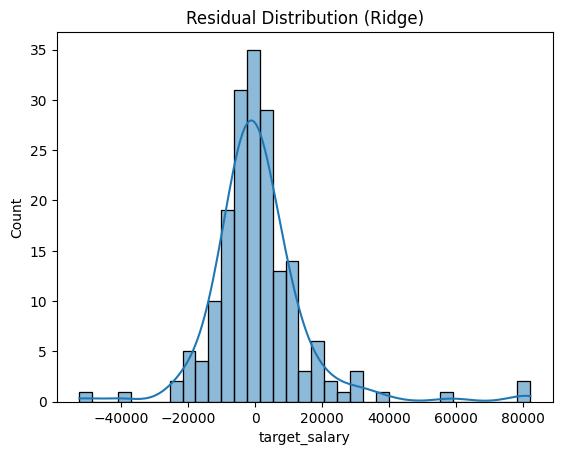

In [39]:
#Residual Distribution (Check Normality)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Ridge)")
plt.show()

#Bell-shaped = residuals roughly normal

/tmp/ipython-input-29-1525903955.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_dlr, plot_type="bar")


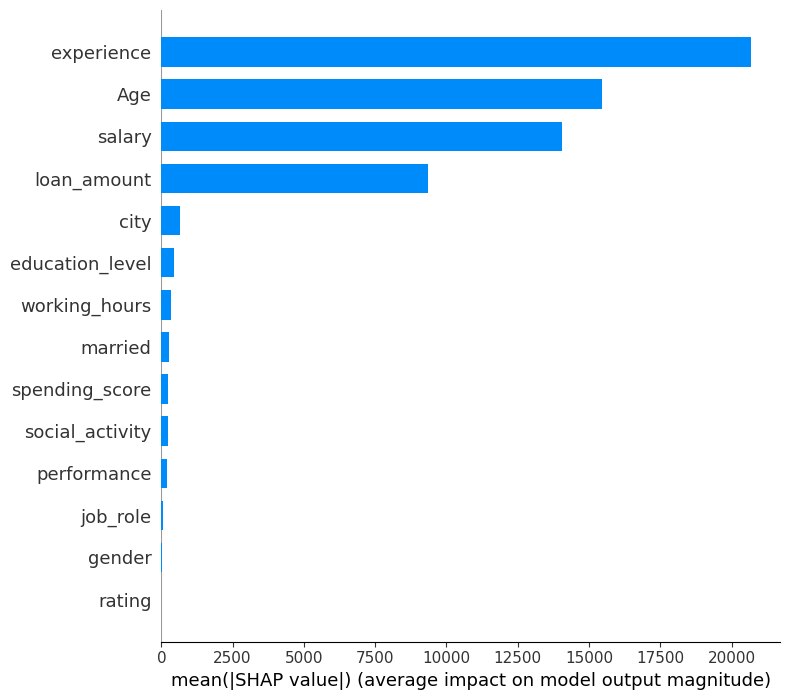

In [29]:
# Step 6: SHAP Explainability
features = X.columns
x_train_dlr = pd.DataFrame(x_train, columns=features)

import shap

explainer = shap.Explainer(model, x_train_dlr)
shap_values = explainer(x_train_dlr)

shap.summary_plot(shap_values, x_train_dlr, plot_type="bar")
